# Mobilenetv2 for Testing
We are going to use a mobilnet to train a model and see how it does

____

## Loading Packages

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 #for our model
from tensorflow.keras.utils import Sequence # For our own data generator
import cv2 # For image processing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder #for hot encoding the target var

## Building Generator

In [248]:
#https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self,
                 csv_file, # file that has the images on it, as well as the image types
                 y_var = ['root','vowel','consonant'] ,
                 to_fit=True,
                 batch_size=32,
                 dim = (90,160),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (0,0), #PRob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=True):
        """Initialization
        :param csv_File #CSV file that has the path to the stores on it
        :param y_var: a list of 'root','voewl','consonant'
        :param to_fit: Provive the dependent variable as well
        :param batch_size: The size of each batch to deliver
        :param dim: dimensions of the photos to use
        :param channels: The number of channals of the photo - 1 is bw, 3 is color, any other is customer
        :param vertical_flip: (dbl) The percent chance to flip a photo along a vertical axis
        :param horizontal_flip: (dbl) The percent chance to flip a photo along a horiszontal axis
        :param rotate: (tuple - (prob, degree)) A two unit tuple, first is the % chance of rotate, the next is the amount of rotation
        :param shear: (tuple - (prob, amt)) A two unit tuple, first is the % chance of shear, the next is the amount of shear
        :param shuffle: True to shuffle label indexes after every epoch
        """
        
        #Getting Index that we will use to sort
        
        self.Idx_List = np.arange(csv_file.shape[0])
        
        # Loading y_Vars
        if isinstance(y_var, list):
            y_var = y_var[0]
            
        if y_var == 'root':
            self.y_var = csv_file.grapheme_root.values
        elif y_var =='vowel':
            self.y_var = csv_file.vowel_diacritic.values
        elif y_var == 'consonant':
            self.y_var = csv_file.consonant_diacritic.values
        else:
            print("Could not determine what y_var was, please use one of 'root','vowel','const'")
        #TODO Move this to the aabove if statement, removing the need for y_var, and y
        self.y_dim = 0
        self.hot_encode_y()
        
        # getting Images Location
        self.Imgs = CSV.Image_Dir.values
        
        #Setting other vars
        self.batch_size = batch_size
        self.fit = to_fit
        self.shuffle = shuffle
        
        self.dim = dim
        self.channels = channels
        if self.channels == 1:
            self.read_mode = cv2.IMREAD_GRAYSCALE
        elif self.channels == 3:
            self.read_mode = cv2.IMREAD_COLOR
        else:
            self.read_mode = cv2.IMREAD_UNCHANGED
        
        assert 0 <= vertical_flip <=1, "vertical_flip = {}, which is not between 0 or 1".format(vertical_flip)
        self.v_flip = vertical_flip
        
        assert 0 <= horizontal_flip <=1, "horizontal_flip = {}, which is not between 0 or 1".format(horizontal_flip)
        self.h_flip = horizontal_flip
        
        assert 0 <= rotate[0] <=1, "first value of rotate = {}, which is not between 0 or 1".format(rotate[0])
        self.r_prob = rotate[0]
        assert 0 <= rotate[1] < 360, "second value of rotate = {}, which is not between 0 or 359".format(rotate[1])
        self.r_deg = rotate[1]
        
        assert 0 <= shear[0] <=1, "first value of shear = {}, which is not between 0 or 1".format(shear[0])
        self.s_prob = shear[0]
        
        assert 0 <= shear[1] <=359, "first value of shear = {}, which is not between 0 or 359".format(shear[1])
        self.s_fact = shear[1]
        #self.on_epoch_end()
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.Idx_List) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        Batch_Idx = self.Idx_List[index * self.batch_size:(index + 1) * self.batch_size]


        # Generate data
        X = self._generate_X(Batch_Idx)

        if self.fit:
            y = self._generate_y(Batch_Idx)
            return X, y
        else:
            return X
        
    #TODO at a def __iter__ and __next__ methodology so we can loop through it!

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.Idx_List)

    def _generate_X(self, Batch_Idx):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.channels))

        # Generate data
        for i, ID in enumerate(Batch_Idx):
            # Store sample
            X[i,] = self._load_image(self.Imgs[ID])

        return X

    def _generate_y_bck(self, Batch_Idx):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(Batch_Idx):
            # Store sample
            y[i,] = self._load_image(self.mask_path + self.labels[ID])

        return y
    
    def _generate_y(self, Batch_Idx):
        y = self.y[Batch_Idx,:]
        return y
    
    def hot_encode_y(self):
        self.y = pd.get_dummies(pd.Categorical(self.y_var)).values
        print("Number of Encodings is {}".format(self.y.shape[1]))
        self.y_dim = self.y.shape[1]
        


    def _load_image(self, image_path):
        
        img = cv2.imread(image_path,  self.read_mode) #load an image as grayscale
        
        if img.shape != self.dim:
            img = cv2.resize(img, self.dim)
        
        img = self._flip_vertical(img)
        
        img = self._flip_horizontal(img)
        
        img = self._rotate(img)
        
        img = self._shear(img)
        
        img = img/255.0
        
        img = img.reshape(self.dim[0],self.dim[1],self.channels)

        return(img)
        
    def _flip_vertical(self, img):
        """Flips and image on a  vertica axis, as set by v_flip,
        if set to zero, will never flip the image """
        if 1 - self.v_flip < np.random.uniform():
            img = cv2.flip(img,1)
            return(img)
        else:
            return(img)
        
    def _flip_horizontal(self, img):
        """Flips and image on a horizontal axis, as set by v_flip,
        if set to zero, will never flip the image """
        if 1 - self.h_flip < np.random.uniform():
            img = cv2.flip(img,0)
            return(img)
        else:
            return(img)
        
    def _rotate(self, img):
        if 1 - self.r_prob < np.random.uniform():
            rows, cols = img.shape[0], img.shape[1]
            #TODO allow a rotation both forward and backwards
            Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), np.random.uniform(self.r_deg), 1)
            img = cv2.warpAffine(img, Rot_M, (cols, rows))
            return(img)
        else:
            return(img)
        
    def _shear(self, img):
        """
        https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/
        """
        if 1 - self.s_prob < np.random.uniform():
            #TODO allow a shear both forward and backwards
            rows, cols = img.shape[0], img.shape[1]
            
            shear_factor = np.random.uniform(self.s_fact)
            
            M = np.array([[1, shear_factor, 0],[0,1,0]])
            nW =  RR.shape[1] + abs(shear_factor*img.shape[0])
            img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
            img = cv2.resize(img, (cols,rows))
            return(img)
        else:
            return(img)

## Reading in CSV training Spot

In [2]:
CSV = pd.read_csv('../Data/train_extra.csv')
CSV.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,Train,Image_Dir
0,Train_0,15,9,5,ক্ট্রো,0,../Data/Train/Train_0.jpg
1,Train_1,159,0,0,হ,0,../Data/Train/Train_1.jpg
2,Train_2,22,3,5,খ্রী,0,../Data/Train/Train_2.jpg
3,Train_3,53,2,2,র্টি,1,../Data/Test/Train_3.jpg
4,Train_4,71,9,5,থ্রো,0,../Data/Train/Train_4.jpg


## Loading Model

In [ ]:
MobileNetV2

In [3]:
TT = np.arange(100)
RR = np.random.choice(100,10,False)
np.delete(TT, RR)

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19,
       20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94,
       95, 96, 97, 98, 99])

In [30]:
CSV.consonant_diacritic.values.shape[0]


200840

In [154]:
#https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self,
                 csv_file, # file that has the images on it, as well as the image types
                 y_var = ['root','vowel','consonant'] ,
                 to_fit=True,
                 batch_size=32,
                 dim = (90,160),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (0,0), #PRob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=True):
        """Initialization
        :param csv_File #CSV file that has the path to the stores on it
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        
        #Getting Index that we will use to sort
        
        self.Idx_List = np.arange(csv_file.shape[0])
        
        # Loading y_Vars
        if isinstance(y_var, list):
            y_var = y_var[0]
            
        if y_var == 'root':
            self.y_var = csv_file.grapheme_root.values
        elif y_var =='vowel':
            self.y_var = csv_file.vowel_diacritic.values
        elif y_var == 'consonant':
            self.y_var = csv_file.consonant_diacritic.values
        else:
            print("Could not determine what y_var was, please use one of 'root','vowel','const'")
        #TODO Move this to the aabove if statement, removing the need for y_var, and y
        self.y_dim = 0
        self.hot_encode_y()
        
        # getting Images Location
        self.Imgs = CSV.Image_Dir.values
        
        #Setting other vars
        self.batch_size = batch_size
        self.fit = to_fit
        self.shuffle = shuffle
        
        self.dim = dim
        self.channels = channels
        if self.channels == 1:
            self.read_mode = cv2.IMREAD_GRAYSCALE
        elif self.channels == 3:
            self.read_mode = cv2.IMREAD_COLOR
        else:
            self.read_mode = cv2.IMREAD_UNCHANGED
        
        self.v_flip = vertical_flip
        self.h_flip = horizontal_flip
        
        self.r_prob = rotate[0]
        self.r_deg = rotate[1]
        
        self.s_prob = shear[0]
        self.s_fact = shear[1]
        #self.on_epoch_end()
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.Idx_List) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        Batch_Idx = self.Idx_List[index * self.batch_size:(index + 1) * self.batch_size]


        # Generate data
        X = self._generate_X(Batch_Idx)

        if self.fit:
            y = self._generate_y(Batch_Idx)
            return X, y
        else:
            return X
        
    #TODO at a def __iter__ and __next__ methodology so we can loop through it!

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.Idx_List)

    def _generate_X(self, Batch_Idx):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.channels))

        # Generate data
        for i, ID in enumerate(Batch_Idx):
            # Store sample
            X[i,] = self._load_image(self.Imgs[ID])

        return X

    def _generate_y_bck(self, Batch_Idx):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(Batch_Idx):
            # Store sample
            y[i,] = self._load_image(self.mask_path + self.labels[ID])

        return y
    
    def _generate_y(self, Batch_Idx):
        y = self.y[Batch_Idx,:]
        return y
    
    def hot_encode_y(self):
        self.y = pd.get_dummies(pd.Categorical(self.y_var)).values
        print("Number of Encodings is {}".format(self.y.shape[1]))
        self.y_dim = self.y.shape[1]
        


    def _load_image(self, image_path):
        
        img = cv2.imread(image_path,  self.read_mode) #load an image as grayscale
        
        if img.shape != self.dim:
            img = cv2.resize(img, self.dim)
        
        img = self._flip_vertical(img)
        
        img = self._flip_horizontal(img)
        
        img = self._rotate(img)
        
        img = self._shear(img)
        
        img = img/255.0
        
        img = img.reshape(self.dim[0],self.dim[1],self.channels)

        return(img)
        
    def _flip_vertical(self, img):
        """Flips and image on a  vertica axis, as set by v_flip,
        if set to zero, will never flip the image """
        if 1 - self.v_flip < np.random.uniform():
            img = cv2.flip(img,1)
            return(img)
        else:
            return(img)
        
    def _flip_horizontal(self, img):
        """Flips and image on a horizontal axis, as set by v_flip,
        if set to zero, will never flip the image """
        if 1 - self.h_flip < np.random.uniform():
            img = cv2.flip(img,0)
            return(img)
        else:
            return(img)
    def _rotate(self, img):
        if 1 - self.r_prob < np.random.uniform():
            rows, cols = img.shape[0], img.shape[1]
            Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), np.random.uniform(self.r_deg), 1)
            img = cv2.warpAffine(img, Rot_M, (cols, rows))
            return(img)
        else:
            return(img)
        
    def _shear(self, img):
        """
        https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/
        """
        if 1 - self.s_prob < np.random.uniform():
            rows, cols = img.shape[0], img.shape[1]
            
            shear_factor = np.random.uniform(self.s_fact)
            
            M = np.array([[1, shear_factor, 0],[0,1,0]])
            nW =  RR.shape[1] + abs(shear_factor*img.shape[0])
            img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
            img = cv2.resize(img, (cols,rows))
            return(img)
        else:
            return(img)
        


In [160]:
dg = DataGenerator(csv_file = CSV, vertical_flip = 0.5, horizontal_flip = 0.5, shear = (0.5, 0.5))

Number of Encodings is 168


In [241]:
xxx = 101

assert 1 < xxx < 100, '{} is not between 1 and 100'.format(xxx)
print(1)

AssertionError: 101 is not between 1 and 100

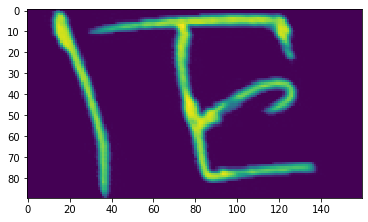

In [239]:
XX, YY = dg[1]

plt.imshow(XX[31].reshape(90,160))

In [162]:
XX[1].reshape(90,160)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
RR = cv2.imread('../Data/Train/Train_0.jpg', cv2.IMREAD_GRAYSCALE)
RR = RR.reshape(90,160,1)
RR.shape

(90, 160, 1)

TypeError: Invalid shape (90, 160, 1) for image data

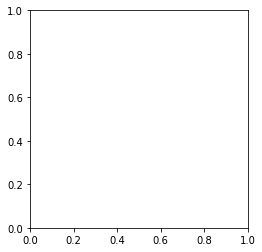

In [54]:
plt.imshow(RR)

In [56]:
XX = (1,2,3)
YY = (1,2,4)

XX == YY

False

In [120]:
 cv2.cvtColor(RR, cv2.COLOR_BGR2GRAY).shape

(90, 160)

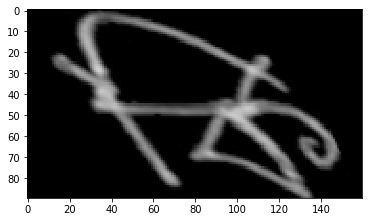

In [105]:
rows, cols = RR.shape[0], RR.shape[1]a
shear_factor = np.random.uniform(0.5)
M = np.array([[1, shear_factor, 0],[0,1,0]])
nW =  RR.shape[1] + abs(shear_factor*RR.shape[0])
img_shr = cv2.warpAffine(RR, M, (int(nW), RR.shape[0]))
img_shr = cv2.resize(img_shr, (cols,rows))
plt.imshow(img_shr)

In [245]:
?cv2.getRotationMatrix2D

Docstring:
getRotationMatrix2D(center, angle, scale) -> retval
.   @brief Calculates an affine matrix of 2D rotation.
.   
.   The function calculates the following matrix:
.   
.   \f[\begin{bmatrix} \alpha &  \beta & (1- \alpha )  \cdot \texttt{center.x} -  \beta \cdot \texttt{center.y} \\ - \beta &  \alpha &  \beta \cdot \texttt{center.x} + (1- \alpha )  \cdot \texttt{center.y} \end{bmatrix}\f]
.   
.   where
.   
.   \f[\begin{array}{l} \alpha =  \texttt{scale} \cdot \cos \texttt{angle} , \\ \beta =  \texttt{scale} \cdot \sin \texttt{angle} \end{array}\f]
.   
.   The transformation maps the rotation center to itself. If this is not the target, adjust the shift.
.   
.   @param center Center of the rotation in the source image.
.   @param angle Rotation angle in degrees. Positive values mean counter-clockwise rotation (the
.   coordinate origin is assumed to be the top-left corner).
.   @param scale Isotropic scale factor.
.   
.   @sa  getAffineTransform, warpAffine, transform
Typ

In [246]:
cv2.getRotationMatrix2D((5,5), 30, 1)

array([[ 0.8660254 ,  0.5       , -1.83012702],
       [-0.5       ,  0.8660254 ,  3.16987298]])

In [247]:
cv2.getRotationMatrix2D((5,5), -30, 1)

array([[ 0.8660254 , -0.5       ,  3.16987298],
       [ 0.5       ,  0.8660254 , -1.83012702]])